# Wide & Deep Learning model 구현

저희는 추천 시스템을 적용하기 위해서 `Wide & Deep` 모델을 사용했습니다. 

모델 구현에 대한 간단한 설명을 하겠습니다.  
입력은 2개로 분리해서 생각하면 됩니다.  

`Wide 모델`의 입력: category Feature을 `Polynomial`하게 바꿔준 데이터  
`Deep 모델`의 입력: category Feature을 `embeding` 시켜준 데이터 + `continuous`한 데이터   
<br><br>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

## Data load

In [2]:
df_merge = pd.read_csv('./data/Total_Data_1.csv')
df_merge = df_merge[['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1',
       'cum_act_2', 'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6','sech_clac_nm2',
       'cum_act_7', 'day', 'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp',
       'pty', 'r06', 'clac_nm2','clnt_gender', 'clnt_age']]

df_merge = df_merge.sort_values(['sess_dt', 'hit_tm'])
df_merge.loc[df_merge['clac_nm2'].isnull(),'clac_nm2'] = df_merge['sech_clac_nm2']
df_merge.head()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_gender,clnt_age,label
121082,3390,1,1,0,A01,2019-07-01,00:00,0,NaN,지고트,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,Women's Outwear
194580,5535,1,1,5,A03,2019-07-01,00:00,6532,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,NaN
194581,5535,1,2,0,A03,2019-07-01,00:00,30494,NaN,양파,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Chilled Instant Foods
194582,5535,1,3,3,A03,2019-07-01,00:00,32370,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Chilled Beverages
194583,5535,1,4,0,A03,2019-07-01,00:00,41637,NaN,우엉,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,30,Snacks


<br><br>
## label이 있는 행 추출

In [7]:
df_buyer = df_merge[(df_merge['action_type']==0)|(df_merge['action_type']==6)]
print('구매 이력이 있는 행:', round(len(df_buyer['clac_nm2']) / len(df_merge['clac_nm2']) * 100, 2),'%')

구매 이력이 있는 행: 24.55 %


In [8]:
del df_merge

<br><br>
## 데이터 전처리

### User2Vec 추가

In [10]:
# 유저 임베딩 데이터 load
user2vec = pd.read_csv('./data/user2vec100.csv')

In [11]:
df_buyer = df_buyer[df_buyer['clac_nm2'].notna()]
df_buyer = df_buyer.merge(user2vec, on=['clnt_id', 'sess_id'], how='left')

In [12]:
data = df_buyer.copy()

In [13]:
drop_col=['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'hit_tm', 'trans_id','sech_clac_nm2', 'sess_dt', 'sech_kwd']
df_buyer = df_buyer.drop(drop_col, axis=1)

### <br><br>
## label 데이터 분리

In [14]:
le = LabelEncoder()

lab_len = len(df_buyer['clac_nm2'].value_counts())
label_key = df_buyer['clac_nm2'].value_counts().keys()

df_buyer['clac_nm2'] = le.fit_transform(df_buyer['clac_nm2'])
clac_nm2 = df_buyer['clac_nm2'].copy()
df_buyer.drop(['clac_nm2'], axis=1, inplace=True)

<br><br>
## 데이터 전처리

In [15]:
x_col = []
for i in range(100):
    x_col.append('X_'+str(i))

In [17]:
ALL_COLUMNS = [
    'biz_unit', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',  
       'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1', 'cum_act_2',
       'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6', 'cum_act_7', 'day',
       'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp', 'pty', 'r06',
       'clnt_gender', 'clnt_age'
]

CATEGORICAL_COLUMNS = [
    "biz_unit", 'trfc_src', 'dvc_ctg_nm',  
    'prefer_dvc_trfc', 'clnt_gender', 'clnt_age', 'pty'
]

EMBEDDED_COLUMNS = x_col

CONTINUOUS_COLUMNS = list(set(ALL_COLUMNS).difference(CATEGORICAL_COLUMNS+EMBEDDED_COLUMNS))

In [18]:
df_buyer.loc[df_buyer['clnt_gender'].isnull(),'clnt_gender'] = 'U'
df_buyer.loc[df_buyer['clnt_age'].isnull(),'clnt_age'] =  -1

In [20]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    df_buyer[c] = le.fit_transform(df_buyer[c])

In [21]:
label = clac_nm2.copy()
label = np.eye(lab_len)[label]
label = pd.DataFrame(data=label, columns=label_key, index=df_buyer.index)

<br><br>
## Train 데이터, Test 데이터 분할

In [22]:
train_x, test_x , train_y , test_y = train_test_split(df_buyer , label , test_size=0.05, shuffle=False)

In [23]:
print('Train 데이터: ', train_x.shape)
print('Test 데이터: ', test_x.shape)
print('Train 라벨: ', train_y.shape)
print('Test 라벨: ', test_y.shape)

Train 데이터:  (626819, 124)
Test 데이터:  (32991, 124)
Train 라벨:  (626819, 309)
Test 라벨:  (32991, 309)


In [24]:
train_x, val_x , train_y , val_y = train_test_split(train_x , train_y , test_size=0.1, shuffle=False)

In [25]:
print('Train 데이터: ', train_x.shape)
print('Val 데이터: ', val_x.shape)
print('Train 라벨: ', train_y.shape)
print('Val 라벨: ', val_y.shape)

Train 데이터:  (564137, 124)
Val 데이터:  (62682, 124)
Train 라벨:  (564137, 309)
Val 라벨:  (62682, 309)


<br><br>
## Column 분할

In [26]:
train_x_category = np.array(train_x[CATEGORICAL_COLUMNS])
test_x_category  = np.array(test_x[CATEGORICAL_COLUMNS])
val_x_category   = np.array(val_x[CATEGORICAL_COLUMNS])

train_x_embedding = np.array(train_x[EMBEDDED_COLUMNS])
test_x_embedding  = np.array(test_x[EMBEDDED_COLUMNS])
val_x_embedding   = np.array(val_x[EMBEDDED_COLUMNS])

train_x_continue = np.array(train_x[CONTINUOUS_COLUMNS], dtype='float64')
test_x_continue = np.array(test_x[CONTINUOUS_COLUMNS], dtype='float64')
val_x_continue = np.array(val_x[CONTINUOUS_COLUMNS], dtype='float64')

<br><br>
## 정규화

In [27]:
scaler = StandardScaler()
train_x_continue = scaler.fit_transform(train_x_continue)
test_x_continue = scaler.transform(test_x_continue)
val_x_continue = scaler.transform(val_x_continue)

* 정규화 내용 확인

In [28]:
print(train_x_continue[0].sum())
print(train_x_continue[1].sum())
print(train_x_continue[2].sum())
print(train_x_continue[3].sum())
print(train_x_continue[4].sum())

-11.605023918592604
-11.354365361540133
-11.324531784106053
-11.312471934166016
-11.302824361617713


<br><br>
## Polynomial 적용
    - 카테고리 값을 Polynomial로 바꿔줌

* sklearn.preprocessing.PolynomialFeatures 메소드
    - degree : 다항식 차수
    - interaction_only
        - default는 False
        - ex) degree = 3일 때, interaction_only=false 이면
            - a^2, a^3, b^2, b^3, ab, a^2*b, ab^2 Feature가 추가되고,
        - interaction_only=True 이면
            - ab만 추가됨
        

In [29]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [30]:
train_x_category_poly = poly.fit_transform(train_x_category)
test_x_category_poly = poly.fit_transform(test_x_category)
val_x_category_poly = poly.fit_transform(val_x_category)

In [31]:
train_x_category_poly.shape

(564137, 29)

<br><br>
## 모델 구현

모델 구현에 대한 간단한 설명을 하겠습니다.  
입력은 2개로 분리해서 생각하면 됩니다.  

Wide 모델의 입력: category Feature을 Polynomial하게 바꿔준 데이터  
Deep 모델의 입력: category Feature을 embeding 시켜준 데이터 + continuous한 데이터  

그리고 출력은 lgbm 모델과 마찬가지로 1058개의 prediction 값이 row만큼 출력 됩니다.  

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K

<br>

### 하이퍼 파라미터 튜닝

In [33]:
beta_1 = 0.9
lr = 1e-5
l1 = 0.01
l2 = 0.01
momentum = 0.99

<br>

In [34]:
def get_deep_model():
    
    category_inputs = []
    category_embeds = []
    
    # Categorical Data Embedding
    for i in range(len(CATEGORICAL_COLUMNS)):
        
        # input - embedding - flatten 순으로 layer 쌓기
        input_i = Input(shape=(1,), dtype='int32')
        
        dim = len(np.unique(df_buyer[CATEGORICAL_COLUMNS[i]]))
        
        embed_dim = int(np.ceil(dim ** 0.5))
        
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        # dim : 데이터가 몇 종류 있는지 = 임베딩 벡터를 몇 개 뽑아낼 것인지
        # embed_dim : 임베딩 처리 후 벡터의 차원 = 임베딩 벡터를 몇 차원 벡터로 뽑아 낼 것인지
        # input_length : 입력 데이터 길이
        
        flatten_i = Flatten()(embed_i)
        # category 값을 임베딩환 벡터들을 flatten
        
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
        
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    
    bn_concat = BatchNormalization(momentum=momentum)( concat_embeds)
    
    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    deep = ReLU()(fc3)
    
    return category_inputs, continue_input, deep

In [35]:
# x_train_category_poly : 카테고리 데이터를 숫자로 바꾸고, Poly Feature를 추가한 것
# Poly Feature : a, b, c Feature를 이용해서 ab, bc, ca Feature를 만든것
# 데이터의 shape 만 가져옴
def get_wide_model(poly):
    dim = poly.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

def get_embed_model(embed):
    dim = embed.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

In [36]:
# input - embedding - flatten 순으로 layer 쌓기
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model(train_x_category_poly)
embed_model = get_embed_model(train_x_embedding)

<br><br>
### Wide모델과 Deep model을 합치기

In [37]:
concat = concatenate([deep_model, wide_model, embed_model])
inputs = [continue_input] + category_inputs + [wide_model] + [embed_model]
output = Dense(len(label_key), activation='sigmoid')(concat)
model = Model(inputs=inputs, outputs=output)

In [38]:
len(inputs)

10

<br><br>
### 입력 데이터

    * 위에서 정의한 리스트 변수 inputs에 맞추어
    * continue 데이터 => category 데이터 => poly data 순으로 입력 값을 넣어준다

In [40]:
input_data = [train_x_continue] + [train_x_category[:, i] \
             for i in range(train_x_category.shape[1])] + \
             [train_x_category_poly] + [train_x_embedding]

val_data = [val_x_continue] + [val_x_category[:, i] \
            for i in range(val_x_category.shape[1])] + \
            [val_x_category_poly] + [val_x_embedding]

<br><br>
## 학습 진행

In [41]:
def binary_crossentropy(y_true, y_pred):
    true = K.equal(y_true, 1.0 ) 
    true2 = K.cast(true , dtype = float)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

gamma = 2.0
epsilon = K.epsilon()

def focal_loss(y_true, y_pred):
    # https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss
    return K.mean(K.sum(loss, axis=1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr, beta_1=beta_1),
              loss=focal_loss   , # focal_loss  ,  # 'binary_crossentropy',
              metrics=[ binary_crossentropy ]) 

In [42]:
checkpoint_path = "./ckpt/my_checkpoint/KM-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_loss',
                                                 save_best_only = True , 
                                                 save_freq = 'epoch' , 
                                                 mode='auto' ,
                                                 verbose=1)
# step 별로 learning rate를 조절합니다. 
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return tf.keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=lr, decay_factor=0.8, step_size=2)

  # `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
Early = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, 
                                         patience=10 ,
                                         monitor='val_loss')

In [43]:
epochs = 500
batch_size = 128

In [44]:
history = model.fit(input_data, train_y, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=(val_data, val_y), 
                  callbacks=[lr_sched, Early, cp_callback])

Epoch 1/500
4398/4408 [============================>.] - ETA: 0s - loss: 44.7882 - binary_crossentropy: 0.2894
Epoch 00001: val_loss improved from inf to 2.96149, saving model to ./ckpt/my_checkpoint/KM-0001.ckpt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0001.ckpt/assets
4408/4408 [==============================] - 14s 3ms/step - loss: 44.6995 - binary_crossentropy: 0.2890 - val_loss: 2.9615 - val_binary_crossentropy: 0.0701
Epoch 2/500
4393/4408 [============================>.] - ETA: 0s - loss: 2.4240 - binary_crossentropy: 0.0625
Epoch 00002: val_loss improved from 2.96149 to 2.15044, saving model to ./ckpt/my_checkpoint/KM-0002.ckpt
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0002.ckpt/assets
4408/4408 [=================

In [45]:
model.save('./model/widendeep_model')

INFO:tensorflow:Assets written to: ./model/widendeep_model/assets


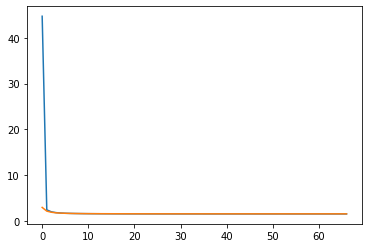

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

<br><br>
## 정확도 평가

In [50]:
# train input data와 같은 방식으로 test data를 input 형식에 맞추어줌
eval_input_data = [test_x_continue] + [test_x_category[:, i] for i in range(test_x_category.shape[1])] + [test_x_category_poly] + [test_x_embedding]

In [51]:
loss, acc = model.evaluate(eval_input_data, test_y)

1031/1031 [==============================] - 1s 1ms/step - loss: 1.5621 - binary_crossentropy: 0.0655


In [52]:
prob = model.predict(eval_input_data)

In [71]:
test_x = data.loc[test_x.index]

In [73]:
# one-hot에서 같은 trans_id는 더해줌.
receipt_y = test_y.copy()
receipt_y['trans_id'] = test_x['trans_id']
frame = pd.DataFrame(data = receipt_y['trans_id'], columns=['trans_id'])
receipt_y = receipt_y.groupby('trans_id', as_index=False).sum()
receipt_y = frame.merge(receipt_y, how='left').set_index(test_x.index)
receipt_y.drop('trans_id', axis=1, inplace=True)

In [74]:
receipt_y.head()

,Chilled Snacks,Snacks,Hot Snacks,Women's Upper Bodywear / Tops,Chilled Instant Foods,Bakery,Lighting Accessories,Biscuits,Ham and Sausages,Fish Cakes and Crab Sticks,...,Other Ball Game / Field Sports,Grain Gift Sets,Sea Food Gift Sets,Car Accessories,Business Paper Products,Writing Supplies,Vegetable Gift Sets,Car Wash Equipment,Safety Equipment,Improvement Supplies
626819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# 같은 영수증 별로 구매 아이템을 묶어주는 작업.
test_label = data.loc[test_x.index][['clnt_id','sess_id', 'clac_nm2']]
frame = pd.DataFrame(data = test_label[['clnt_id','sess_id']], columns=['clnt_id', 'sess_id'])
test_label = test_label.groupby(['clnt_id','sess_id'])['clac_nm2'].apply(lambda x: ', '.join(x))
test_label = frame.merge(test_label, on=['clnt_id', 'sess_id'],how='left').set_index(test_x.index)

In [76]:
test_label.head(18).tail(5)

,clnt_id,sess_id,clac_nm2
626832,31350,91,"Women's Lower Bodywear / Bottoms, Women's Lowe..."
626833,37794,114,"Traditional Rice Cakes, Hot Snacks"
626834,37794,114,"Traditional Rice Cakes, Hot Snacks"
626835,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."
626836,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."


In [77]:
score_pd = pd.DataFrame(prob, columns=receipt_y.columns)
cond = list(np.sum(receipt_y.values, axis=1) > 10)
cond_pd = score_pd[cond].reset_index(drop= True)
test_pd = test_label[cond].reset_index(drop= True)

In [87]:
''' 
pred_matrix: 예측된 아이템 행렬 파라미터.
top_n: 상위 몇개를 추천으로 사용할 지 정하는 파라미터.
test_matix: 고객ID와 Target이 있는 행렬 파라미터
'''
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k for k in test_matix["clac_nm2"][i].split(', ')]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Accuracy of Top {}: {:>.3f}%\n".format(top_n, avg_acc*100))
    return avg_acc, match_list

In [88]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)
    
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

In [89]:
accuracy, match_list =  get_acc(cond_pd, 5 , test_pd) 
map_val = mean_average_precision(match_list)
print("MAP: {:.3}%".format(map_val*100))

Accuracy of Top 5: 7.573%

MAP: 16.6%


<br><br>
## 결과 시각화

In [90]:
def get_pred_list(predict_y, top_n, target_matrix):
    test_matrix = target_matrix.copy()
    pred_matrix = predict_y.copy()
    for i in range(len(pred_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        top = pd.DataFrame(top.astype(str).to_frame().apply(lambda x: ", ".join(x)))
        test_matrix.loc[i, 'pred'] = top.values[0]
    return test_matrix

In [91]:
d={'word': clac_nm2, 'label': data['clac_nm2']}
df = pd.DataFrame(data=d).drop_duplicates()
cate2papago = df.set_index('label').to_dict()

In [92]:
test = get_pred_list(cond_pd, 5, test_pd)

In [94]:
test = test.groupby('sess_id', as_index=False).first()

In [95]:
def id_to_item(test, column_name):
    item_list = []
    for i in range(test.shape[0]):
        tmp_list = []
        for a in test.iloc[i][column_name].split(', '):
            tmp_list.append(a)
        item_list.append(tmp_list)
    return item_list

In [96]:
test

,sess_id,clnt_id,clac_nm2,pred
0,1,7090,"Instant Noodles, Dried Noodles, Dried Noodles,...","Leaf Vegetables, Fruit Vegetables, Dessert, An..."
1,2,63998,"Chilled Instant Foods, Lighting Accessories, F...","Fruit Vegetables, Kids' Underwear, Leaf Vegeta..."
2,3,60449,"Packaged Side Dishes, Bakery, Hot Snacks, Seas...","Travel Bags, Fruit Vegetables, Fitness Trainin..."
3,4,30297,"Eggs, Processed Seaweeds, Processed Seaweeds, ...","Fruit Vegetables, Hand / Foot Care, Leaf Veget..."
4,5,24029,"Chilled Snacks, Chilled Snacks, Bakery, Chille...","Hand / Foot Care, Fitness Training, Kids' Unde..."
...,...,...,...,...
75,130,45092,"Ham and Sausages, Chilled Snacks, Ham and Saus...","Fruit Vegetables, Meat Gift Sets, Women's Gene..."
76,134,15518,"Biscuits, Processed Milk, Frozen Instant Foods...","Meat Gift Sets, Boys' Full Bodywear, Hand / Fo..."
77,138,35673,"Mushrooms, Yogurt, Biscuits, Frozen Instant Fo...","Hand / Foot Care, Kids' Underwear, Yogurt, Pre..."
78,196,62232,"Leaf Vegetables, Frozen Instant Foods, Tissues...","Fruit Vegetables, Chilled Beverages, Girls' Ou..."


In [102]:
def remove_dup(li):
        my_set = set()
        res = []
        for e in li:
            if e not in my_set:
                res.append(e)
                my_set.add(e)
        return res

In [103]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k.split(", ")[0] for k in test_matix["clac_nm2"][i].split()]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))
    return avg_acc, match_list

In [104]:
def show_with_table(a, b, index):
    buy_list = remove_dup(a[index])
    rec_list = remove_dup(b[index])
    tmp=[]
    match = np.zeros(len(b[index])).astype(np.int8).tolist()
    for j in range(len(rec_list)):
        if rec_list[j] in buy_list :
            tmp.append(str(j)+'번째: '+rec_list[j])
            match[j] = 1
    df1 = pd.DataFrame({"They buy": buy_list})
    df2 = pd.DataFrame({"We recommend" : rec_list})
    df = pd.concat([df1, df2], axis=1, sort=False)
    
    print(index, "번째 로그 데이터에 대한 결과\n")
    display(df)
    print("추천 적중 상품:", tmp)
    print("\nAP:", average_precision(match))

In [105]:
def find_good_case(a, b, criteria=0.5):
    good_map=[]
    for index in range(len(a)):
        buy_list = remove_dup(a[index])
        rec_list = remove_dup(b[index])
        match = np.zeros(len(b[index])).astype(np.int8).tolist()
        for j in range(len(rec_list)):
            if rec_list[j] in buy_list :
                match[j] = 1
        good_map.append(average_precision(match))
    best_idx = []
    for idx, v in enumerate(good_map):
        if v >= criteria:
            best_idx.append(idx)
    return best_idx

In [106]:
good_case_idx = find_good_case(a, b, 0.7)

In [107]:
show_with_table(a,b, good_case_idx[0])

2 번째 로그 데이터에 대한 결과



,They buy,We recommend
0,Packaged Side Dishes,Travel Bags
1,Bakery,Fruit Vegetables
2,Hot Snacks,Fitness Training
3,Seasoned Meats,Leaf Vegetables
4,Chickens,Hand / Foot Care
5,Chilled Snacks,NaN
6,Travel Bags,NaN
7,Ham and Sausages,NaN
8,Snacks,NaN
9,Curtains / Blinds,NaN


추천 적중 상품: ['0번째: Travel Bags', '1번째: Fruit Vegetables', '3번째: Leaf Vegetables']

AP: 0.9166666666666666


<br><br>
## Entropy Diversity 
- 추천 결과가 얼마나 분산 되어 있느냐를 평가

In [108]:
import math
ideal = 'abcde'
probid = [ float(ideal.count(c)) / len(ideal) for c in dict.fromkeys(list(ideal))]
entropy_ideal = - sum([ p * math.log(p) / math.log(2.0) for p in probid ])

In [109]:
entropy_ideal = - sum([ p * math.log(p) for p in probid])
entropy_ideal

1.6094379124341005

In [110]:
def entropy_diversity(li):
    total = []
    for first_list in li:
        for items in first_list:
            total.append(items)
    total_unique = list(set(total))
    probid = [ float(total.count(c)) / len(total) for c in total_unique]
    entropy_ideal = - sum([ p * math.log(p) for p in probid])
    return entropy_ideal

In [111]:
entropy_diversity(b)

2.6985442459601057